<a target="_blank" href="https://colab.research.google.com/github/markusmeister/MIB-Public/blob/master/Figures_Ch_2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Ch 2 - Basics of Linear Algebra

This notebook contains python code for generating figures in Chapter 2 of the book _Mathematics in Biology_.

## Imports and utilities

In [51]:
import numpy as np
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

data_url = 'https://raw.githubusercontent.com/markusmeister/MIB-Public/master/data/'

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('../img')
    savedir.mkdir(parents=True, exist_ok=True)

In [52]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                                 histtype=histtype, stacked=stacked, align=align,
                                 color=col, alpha=alpha, linewidth=linewidth,
                                 label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

## How to read data from a Github repo?
Can access files in a public Github repo using `raw.githubusercontent.com`.

In [53]:
# CSV using pandas
import pandas as pd

url = "https://raw.githubusercontent.com/markusmeister/MIB-Public/master/data/test.csv"
c = pd.read_csv(url)
c

,1,2,3


In [54]:
# pickle file
import pickle
import requests

url = "https://raw.githubusercontent.com/markusmeister/MIB-Public/master/data/test.pkl"
response = requests.get(url)
# response.raise_for_status()  # Raise an exception for bad status codes
data = pickle.loads(response.content)
print(data)

[1, 2, 3]


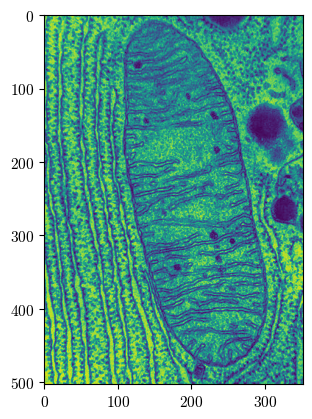

In [55]:
from PIL import Image
import requests

url = data_url+'mito.tif'
im = np.array(Image.open(requests.get(url, stream=True).raw))
plt.imshow(im);

# Basics of Linear Algebra

## Introduction

In [56]:
# load data 
url = data_url + 'Impulses2'
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes
(Lx,Ly),(Bx,By),(Jx,Jy),(Gx,Gy),(Cx,Cy),(Kx,Ky) = pickle.loads(response.content)

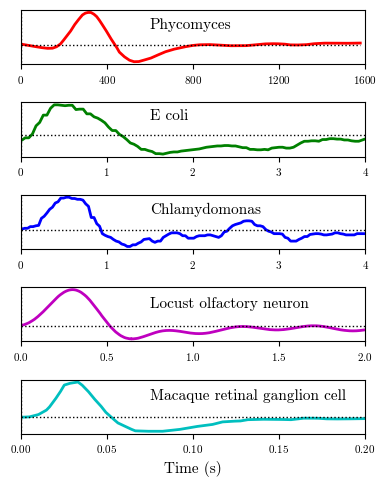

In [57]:
# plot and save
# # Include the second macaque cell (Kx,Ky)
fig,axes=plt.subplots(nrows=5,figsize=(4,5))
data=zip([Lx,Bx,Jx,Gx,Kx],[Ly,By,Jy,Gy,Ky])
fmts=['r-','g-','b-','m-','c-']
sign=[1,1,-2,-2,1]
xlim=[1600,4,4,2,0.2]

for ax,(x,y),s,f,l in zip(axes,data,sign,fmts,xlim):
    y1=s*y/np.max(s*y) # make positive and scale to max of 1
    plot(x,y1,fmts=[f],axes=ax);
    plot([x[0],x[-1]],[0,0],fmts=['k:'],linewidth=1,axes=ax);
    plot([0,0],[np.min(y1),np.max(y1)],fmts=['k:'],linewidth=1,axes=ax);
    ax.set_xlim([0,l])
    ax.yaxis.set_ticks([])
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis='x',labelsize=8)
ax.set_xlabel('Time (s)')
axes[0].text(600,0.5,'Phycomyces');
axes[1].text(1.5,0.5,'E coli');
axes[2].text(1.5,0.5,'Chlamydomonas');
axes[3].text(0.75,0.5,'Locust olfactory neuron');
axes[4].text(0.075,0.5,'Macaque retinal ganglion cell');
plt.tight_layout()

if Save:
    plt.savefig(str(savedir)+'/Impulses2.pdf',bbox_inches='tight')

## Linear operators

/var/folders/t7/6fcx_5ws6tg6315x16vsfxxm0000gn/T/ipykernel_1986/204053334.py:19: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Arc((0,0),1,1,0,
/var/folders/t7/6fcx_5ws6tg6315x16vsfxxm0000gn/T/ipykernel_1986/204053334.py:62: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Arc((0,0),1,1,0,


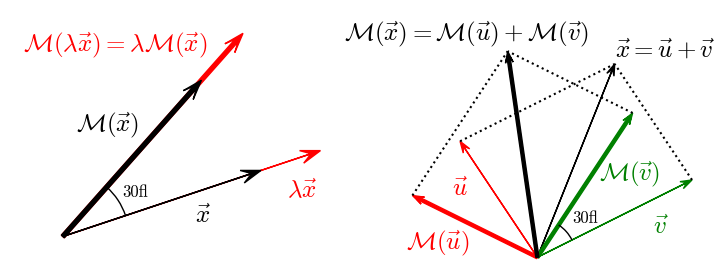

In [58]:
from matplotlib.patches import Arc

def plot0(ax):
    x=[1.5,.5]
    an=30
    la=1.3
    c=np.cos(an*np.pi/180)
    s=np.sin(an*np.pi/180)
    Mx=[x[0]*c-x[1]*s,x[0]*s+x[1]*c]
#     fig,ax=plt.subplots(1,1,figsize=(4,4))
    ax.arrow(0,0,la*x[0],la*x[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,la*Mx[0],la*Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.arrow(0,0,Mx[0],Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.add_patch(Arc((0,0),1,1,0,
                     np.arctan(x[1]/x[0])*180/np.pi,
                     np.arctan(Mx[1]/Mx[0])*180/np.pi, 
                     linewidth=1, color='black')) # draw arc
    ax.text(0.45,0.3,'{:.0f}°'.format(an),fontsize=12)
    ax.text(1.,0.1,r'$\vec x$',fontsize=18)
    ax.text(1.7,0.3,r'$\lambda \vec x$',color='red',fontsize=18)
    ax.text(0.1,0.8,r'$\mathcal{M}(\vec x)$',fontsize=18)
    ax.text(-0.3,1.4,r'$\mathcal{M}(\lambda \vec x) = \lambda \mathcal{M}(\vec x)$',color='red',fontsize=18)
    ax.set_xlim((-0.4,2.0))
    ax.set_ylim((-0.1,1.6))
    ax.set_aspect('equal')
    ax.axis('off')
#     plt.show()

def plot1(ax):
    v=np.array([2,1])
    u=np.array([-1,1.5])
    an=30.0
    x=u+v
    c=np.cos(an*np.pi/180)
    s=np.sin(an*np.pi/180)
    M=np.array([[c,-s],[s,c]])
    Mv=M.dot(v)
    Mu=M.dot(u)
    Mx=M.dot(x)
#     fig,ax=plt.subplots(1,1,figsize=(4,4))
    ax.arrow(0,0,u[0],u[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,v[0],v[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='green')
    ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.arrow(0,0,Mu[0],Mu[1],width=0.04,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='red')
    ax.arrow(0,0,Mv[0],Mv[1],width=0.04,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='green')
    ax.arrow(0,0,Mx[0],Mx[1],width=0.04,length_includes_head=True,head_width=0.1,
            overhang=0.5,color='black')
    ax.plot([u[0],x[0]],[u[1],x[1]],'k:')
    ax.plot([v[0],x[0]],[v[1],x[1]],'k:')
    ax.plot([Mu[0],Mx[0]],[Mu[1],Mx[1]],'k:')
    ax.plot([Mv[0],Mx[0]],[Mv[1],Mx[1]],'k:')
    ax.add_patch(Arc((0,0),1,1,0,
                     np.arctan(v[1]/v[0])*180/np.pi,
                     np.arctan(Mv[1]/Mv[0])*180/np.pi, 
                     linewidth=1, color='black')) # draw arc
    ax.text(0.45,0.45,'{:.0f}°'.format(an),fontsize=12)
    ax.text(1.,2.6,r'$\vec x = \vec u + \vec v$',fontsize=18)
    ax.text(1.5,0.3,r'$\vec v$',fontsize=18,color='green')
    ax.text(-1.1,0.8,r'$\vec u$',fontsize=18,color='red')
    ax.text(0.8,1.0,r'$\mathcal{M}(\vec v)$',fontsize=18,color='green')
    ax.text(-1.7,.1,r'$\mathcal{M}(\vec u)$',fontsize=18,color='red')
    ax.text(-2.5,2.8,r'$\mathcal{M}(\vec x) = \mathcal{M}(\vec u) + \mathcal{M}(\vec v)$',fontsize=18,color='black')
    ax.set_xlim((-1.9,2.2))
    ax.set_ylim((-0.1,3.2))
    ax.set_aspect('equal')
    ax.axis('off')
#     plt.show()

fig,ax=plt.subplots(1,2,figsize=(9,4))
plot0(ax[0])
plot1(ax[1])
if Save:
    fig.savefig(str(savedir / 'rotation-arrows-30deg.pdf'), dpi=600, format='pdf', bbox_inches='tight');

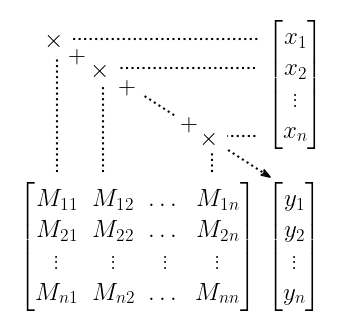

In [59]:
# mnemonic matrix * vector
# import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams['font.size'] = 12
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

fig,ax = plt.subplots(figsize=(4,4))

# ax.plot([.25,.25],[.4,.8],'k:')
ax.text(.2,.2,r'$\begin{bmatrix} M_{11} & M_{12} & \dots & M_{1n} \\ M_{21} & M_{22} & \dots & M_{2n} \\ \vdots & \vdots & \vdots & \vdots\\ M_{n1} & M_{n2} & \dots & M_{nn} \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.7,r'$\begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.2,r'$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}$',
        fontsize=18,color='black')
ax.plot([0.3,0.3,0.95],[0.45,0.86,0.86],'k:')
ax.plot([0.45,0.45,0.95],[0.45,0.77,0.77],'k:')
ax.plot([0.8,0.8,0.95],[0.45,0.56,0.56],'k:')
ax.text(0.3,.86,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.45,.77,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.8,.56,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.37,.805,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.53,.71,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.73,.595,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.plot([0.3,0.98],[0.86,0.44],'k:')
ax.arrow(0.98,0.44,0.01,-0.006,width=0.001,length_includes_head=True,head_width=0.02,
        overhang=0.2)
ax.set_xlim(0.15,1.15)
ax.set_ylim(0,0.95)
ax.axis('off')

if Save:
    fig.savefig(str(savedir / 'matrix-times-vector.pdf'), dpi=600, format='pdf', bbox_inches='tight');

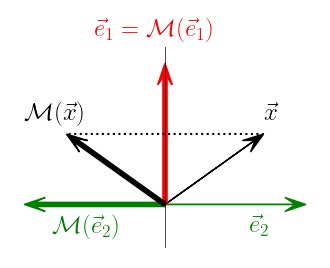

In [60]:
# reflection operator
e1=np.array([0,1])
e2=np.array([1,0])
x=np.array([.7,0.5])
Mx=np.array([-x[0],x[1]])
Me1=np.array([0,1])
Me2=np.array([-1,0])

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.arrow(0,0,e1[0],e1[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,e2[0],e2[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.arrow(0,0,Me1[0],Me1[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,Me2[0],Me2[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,Mx[0],Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.plot([x[0],Mx[0]],[x[1],Mx[1]],'k:')
ax.plot([0,0],[-.3,1.3],'k-',linewidth=0.5)
ax.text(0.7,0.6,r'$\vec x$',fontsize=18)
ax.text(-1,0.6,r'$\mathcal{M}(\vec x)$',fontsize=18)
ax.text(-0.5,1.2,r'$\vec e_1 = \mathcal{M}(\vec e_1)$',
        bbox=dict(facecolor='white',linewidth=0),
        fontsize=18,color='red')
ax.text(0.6,-0.2,r'$\vec e_2$',fontsize=18,color='green')
ax.text(-0.8,-0.2,r'$\mathcal{M}(\vec e_2)$',fontsize=18,color='green')
# ax.set_xlim((-1.9,2.2))
# ax.set_ylim((-0.1,3.2))
ax.set_aspect('equal')
ax.axis('off')
if Save:
    fig.savefig(str(savedir / 'arrow-reflection.pdf'), dpi=600, format='pdf', bbox_inches='tight');

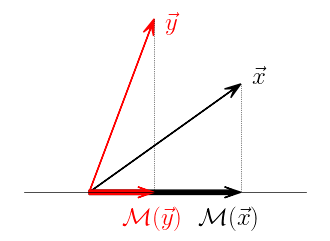

In [61]:
# projection operator
x=np.array([.7,0.5])
y=np.array([.3,0.8])
Mx=np.array([x[0],0])
My=np.array([y[0],0])

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='black')
ax.arrow(0,0,Mx[0],Mx[1],width=0.02,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='black')
ax.arrow(0,0,y[0],y[1],width=0.001,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='red')
ax.arrow(0,0,My[0],My[1],width=0.02,length_includes_head=True,head_width=0.05,
        overhang=0.5,color='red')
ax.plot([-.3,1],[0,0],'k-',linewidth=0.5)
ax.plot([x[0],Mx[0]],[x[1],Mx[1]],'k:',linewidth=0.5)
ax.plot([y[0],My[0]],[y[1],My[1]],'k:',linewidth=0.5)
ax.text(0.75,0.5,r'$\vec x$',fontsize=18)
ax.text(0.35,0.75,r'$\vec y$',fontsize=18,color='red')
ax.text(0.5,-0.15,r'$\mathcal{M}(\vec x)$',fontsize=18)
ax.text(0.15,-0.15,r'$\mathcal{M}(\vec y)$',fontsize=18,color='red')
# ax.set_xlim((-1.9,2.2))
# ax.set_ylim((-0.1,3.2))
ax.set_aspect('equal')
ax.axis('off')
if Save:
    fig.savefig(str(savedir / 'arrow-projection.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Matrix algebra

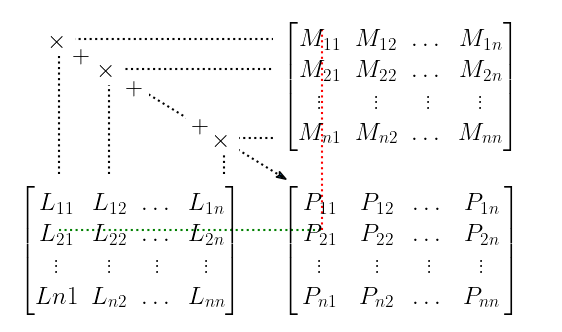

In [62]:
# mnemonic matrix * vector
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# mpl.rcParams['font.size'] = 12
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

fig,ax = plt.subplots(figsize=(7,7))

# ax.plot([.25,.25],[.4,.8],'k:')
ax.text(.2,.2,r'$\begin{bmatrix} L_{11} & L_{12} & \dots &L_{1n} \\ L_{21} & L_{22} & \dots & L_{2n} \\ \vdots & \vdots & \vdots & \vdots\\ L{n1} & L_{n2} & \dots & L_{nn} \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.7,r'$\begin{bmatrix} M_{11} & M_{12} & \dots & M_{1n} \\ M_{21} & M_{22} & \dots & M_{2n} \\ \vdots & \vdots & \vdots & \vdots\\ M_{n1} & M_{n2} & \dots & M_{nn} \end{bmatrix}$',
        fontsize=18,color='black')
ax.text(1,.2,r'$\begin{bmatrix} \,P_{11}\, & \,P_{12}\, & \dots & \,P_{1n}\, \\ \,P_{21}\, & \,P_{22}\, & \dots & \,P_{2n}\, \\ \vdots & \vdots & \vdots & \vdots\\ \,P_{n1}\, & \,P_{n2}\, & \dots & \,P_{nn}\, \end{bmatrix}$',
        fontsize=18,color='black')
ax.plot([0.3,0.3,0.95],[0.45,0.86,0.86],'k:')
ax.plot([0.45,0.45,0.95],[0.45,0.77,0.77],'k:')
ax.plot([0.8,0.8,0.95],[0.45,0.56,0.56],'k:')
ax.text(0.3,.86,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.45,.77,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.8,.56,r'$\times$',
        fontsize=18,color='black',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1))
ax.text(0.37,.805,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.53,.71,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.text(0.73,.595,r'$+$',ha='center',va='center',
        bbox=dict(facecolor='white',linewidth=0,alpha=1),fontsize=18,color='black')
ax.plot([0.3,0.98],[0.86,0.44],'k:')
ax.arrow(0.98,0.44,0.01,-0.006,width=0.001,length_includes_head=True,head_width=0.02,
        overhang=0.2)
ax.plot([1.1,1.1],[0.28,0.9],'r:')
ax.plot([0.3,1.1],[0.28,0.28],'g:')
ax.set_xlim(0.15,1.8)
ax.set_ylim(0,0.95)
ax.set_aspect('equal')
ax.axis('off')
if Save:
    fig.savefig(str(savedir / 'matrix-times-matrix.pdf'), dpi=600, format='pdf', bbox_inches='tight');

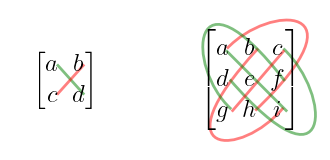

In [63]:
# import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

# mpl.rcParams['font.size'] = 12
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

def Det3D(ax):
    # determinant in 3D mnemonic; uses Bezier curves
    x=np.array([.7,0.5])
    y=np.array([.3,0.8])
    Mx=np.array([x[0],0])
    My=np.array([y[0],0])

    ax.text(.18,.21,r'$\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \end{bmatrix}$',
            fontsize=18,color='black')

    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
    ]

    verts1 = np.array([
       (0.25, 0.34),   # P0
       (0.4, 0.5),  # P1
       (0.75, 0.5),  # P2
       (0.35, 0.12),  # P3
    ])
    path1 = Path(verts1, codes)
    patch1 = patches.PathPatch(path1, facecolor='none', lw=2,edgecolor='red',alpha=0.5)
    ax.add_patch(patch1)

    verts2 = np.array(
      [[ 0.45,  0.13],
       [ 0.3 , -0.05],
       [ 0.  , -0.05],
       [ 0.36,  0.34]]
    )
    path2 = Path(verts2, codes)
    patch2 = patches.PathPatch(path2, facecolor='none', lw=2,edgecolor='red',alpha=0.5)
    ax.add_patch(patch2)
    
    verts3 = np.array(
      [[0.265, 0.125],
       [0.1, 0.275],
       [0.12, 0.66],
       [0.455, 0.225]]
    )
    path3 = Path(verts3, codes)
    patch3 = patches.PathPatch(path3, facecolor='none', lw=2,edgecolor='green',alpha=0.5)
    ax.add_patch(patch3)

    verts4 = np.array(
      [[ 0.45,  0.34],
       [ 0.625,  0.175],
       [ 0.625, -0.19],
       [ 0.26,  0.23]]
    )
    path4 = Path(verts4, codes)
    patch4 = patches.PathPatch(path4, facecolor='none', lw=2,edgecolor='green',alpha=0.5)
    ax.add_patch(patch4)

    diag=np.array([[.27,.12],[.45,.33]])
    ax.plot(diag.T[0],diag.T[1],color='red',alpha=0.5, lw=2)

    diag2=np.array([
        [0.25, 0.33],
        [0.46, 0.12]
    ])
    ax.plot(diag2.T[0],diag2.T[1],color='green',alpha=0.5, lw=2)

    ax.set_xlim((0.08,0.58))
    ax.set_ylim((-0.02,0.48))
    ax.set_aspect('equal')
    ax.axis('off')
    
def Det2D(ax):
    # determinant in 2D mnemonic

    ax.text(.18,.21,r'$\begin{bmatrix} a & b \\ c & d\end{bmatrix}$',
            fontsize=18,color='black')
    diag=np.array([[.25,.28],[.34,.18]])
    ax.plot([diag[0,0],diag[1,0]],[diag[0,1],diag[1,1]],color='green',alpha=0.5, lw=2)
    ax.plot([diag[0,0],diag[1,0]],[diag[1,1],diag[0,1]],color='red',alpha=0.5, lw=2)
    ax.set_xlim((0.08,0.58))
    ax.set_ylim((-0.02,0.48))
    ax.set_aspect('equal')
    ax.axis('off')

    
fig,ax=plt.subplots(1,2,figsize=(4,2))
Det2D(ax[0])
Det3D(ax[1])

if Save:
    fig.savefig(str(savedir / 'determinant-mnemonic.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Change of basis

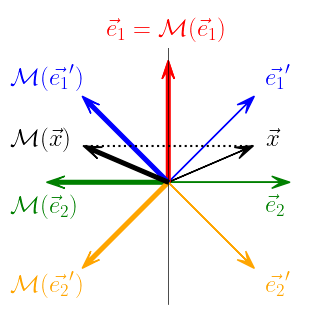

In [64]:
# reflection operator new basis
s2=1/np.sqrt(2)
e1=np.array([0,1])
e2=np.array([1,0])
f1=np.array([s2,s2])
f2=np.array([s2,-s2])

x=np.array([.7,0.3])
Mx=np.array([-x[0],x[1]])
Me1=np.array([0,1])
Me2=np.array([-1,0])
Mf1=np.array([-s2,s2])
Mf2=np.array([-s2,-s2])

fig,ax=plt.subplots(1,1,figsize=(4,4))

ax.arrow(0,0,e1[0],e1[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,e2[0],e2[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,f1[0],f1[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='blue')
ax.arrow(0,0,f2[0],f2[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='orange')
ax.arrow(0,0,x[0],x[1],width=0.001,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.arrow(0,0,Me1[0],Me1[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='red')
ax.arrow(0,0,Me2[0],Me2[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='green')
ax.arrow(0,0,Mf1[0],f1[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='blue')
ax.arrow(0,0,Mf2[0],f2[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='orange')
ax.arrow(0,0,Mx[0],Mx[1],width=0.03,length_includes_head=True,head_width=0.1,
        overhang=0.5,color='black')
ax.plot([x[0],Mx[0]],[x[1],Mx[1]],'k:')
ax.plot([0,0],[-1.,1.3],'k-',linewidth=0.5)
ax.text(0.8,0.3,r'$\vec x$',fontsize=18)
ax.text(-1.3,0.3,r'$\mathcal{M}(\vec x)$',fontsize=18)
ax.text(-0.5,1.2,r'$\vec e_1 = \mathcal{M}(\vec e_1)$',
        bbox=dict(facecolor='white',linewidth=0),
        fontsize=18,color='red')
ax.text(0.8,-0.25,r'$\vec e_2$',fontsize=18,color='green')
ax.text(-1.3,-0.25,r'$\mathcal{M}(\vec e_2)$',fontsize=18,color='green')
ax.text(0.8,0.8,r'${:s}$'.format('\\vec {e_1}\''),fontsize=18,color='blue')
ax.text(-1.3,0.8,r'${:s}$'.format('\\mathcal{M}(\\vec {e_1}\')'),fontsize=18,color='blue')
ax.text(0.8,-0.9,r'${:s}$'.format('\\vec {e_2}\''),fontsize=18,color='orange')
ax.text(-1.3,-0.9,r'${:s}$'.format('\\mathcal{M}(\\vec {e_2}\')'),fontsize=18,color='orange')
# ax.set_xlim((-1.9,2.2))
# ax.set_ylim((-0.1,3.2))
ax.set_aspect('equal')
ax.axis('off')

if Save:
    fig.savefig(str(savedir / 'reflection-basis-transform.pdf'), dpi=600, format='pdf', bbox_inches='tight');